In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Optical calculation
I often like to drive my systems at / near the plasmon resonance. To find it, we can run a spectrum using `g-dda.` 
### Step 1: Define shape and make directories
Set the lattice spacing and radius of the sphere, and make the input files in the following lines. 

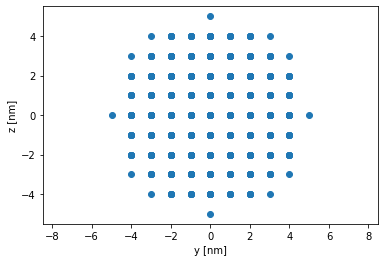

In [2]:
from make_sphere import Generate_Sphere

lat_space = 1 # lattice spacing in nm
radius = 5 # radius of sphere in nm

gen_shape = Generate_Sphere(lat_space=lat_space, radius_nm=radius)
gen_shape.write_shape() # write the shape to a file
gen_shape.plot_shape() # plots the shape

In [3]:
# Delete any previously run folders
from make_dirs import make_directories
import shutil
import glob

files = glob.glob('*eV')
for f in files:
    shutil.rmtree(f)


### Step 2: Make directories
After the shape is made, edit ddscat.par normally. (I haven't made anything fancy yet, so you'll have to go into that file and edit it by hand for now. Once you've edited ddscat.par appropriately, the function `make_directories` will make `num` number of folders which will contain your scattering calculations for each wavelength / energy.

In [4]:
make_directories(intermsof='eV', # eV or nm, only eV for now
                 start=2, # start spectrum at 2.0 eV
                 finish=3, # end spectrum at 3.0 eV
                 num=50 # 50 points in between 
                )

### Step 3: Run scattering calculation
Change this path to wherever you've kept the `g-dda` executables. This will run all the `num` number of calculations. On a laptop, it should take less than a minute. 

In [5]:
%%bash
for i in *eV ; do
    cd $i
    ../../../../g-dda/source_code/ddscat &> output.txt
    cd ../
done

In [6]:
%%bash
for i in *eV ;do
    cd $i
    cp qtable temp
    sed -i -e "1,14d" temp
    cat temp >>../Spectrum
    rm temp
    cd ../
done


### Step 4: Plot spectrum and find resonance


2.408


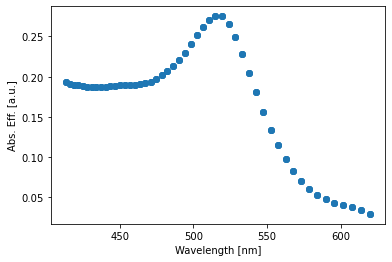

In [7]:
spectrum = np.loadtxt('Spectrum')
plt.scatter(spectrum[:,1]*1000, spectrum[:,3])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Abs. Eff. [a.u.]')
idx = np.where(spectrum[:,3] == max(spectrum[:,3]))
max_wave = np.round(1.240/spectrum[idx,1][0][0],3)
print(max_wave)


### Step 5: Copy inputs and run t-dda
Once you've identified the maximum wavelength / energy, or the wavelength / energy you'd like to run the temperature calculation at, copy those files to a new directory and run `t-dda`. For the above specifications, `t-dda` should run on a laptop in less than a minute.


In [8]:
%%bash -s "$max_wave" 

cp $1_eV/qtable qtable
python sphere_qabs.py
../../source_code/Lattice_Diffusion ../../lattice_greenfunction/Green_grid20.txt var.par tdda_input temp.out


2.161258666037098e-05


### Step 6: Plot the temperature maps
`t-dda` is hardcoded to calculate the temperatures of all the discrete dipoles, as well as any points along the plane specified in the last line of `var.par`. We will plot this plane as a 2D image, or as a 1D slice in the codes below. 

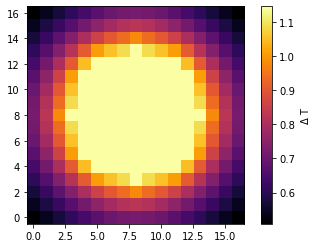

In [9]:
temp_data = np.loadtxt('temp.out')
idx = np.where(temp_data[:,0] == -6)
DS = 1
y = temp_data[idx,1][0]*DS
z = temp_data[idx,2][0]*DS
T = temp_data[idx,3][0]

idx_sort = np.lexsort((y, z))
new_y = y[idx_sort]
new_z = z[idx_sort]
new_temps = T[idx_sort]
y_wind = int(max(y/DS) - min(y/DS) + 1); z_wind = int(max(z/DS) - min(z/DS) + 1)
temp_grid = new_temps.reshape(y_wind, z_wind, order='f')
plt.imshow(temp_grid,origin='lower',cmap='inferno')
plt.colorbar(label='$\Delta$ T')

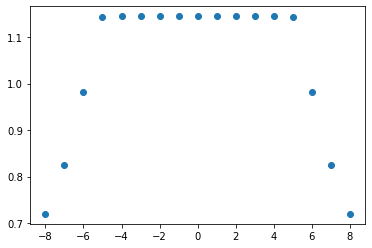

In [10]:
temp_data = np.loadtxt('temp.out')
idx = np.where((temp_data[:,0] == -6) & (temp_data[:,1] == 0 ))
DS = 1
y = temp_data[idx,1][0]*DS
z = temp_data[idx,2][0]*DS
T = temp_data[idx,3][0]
plt.scatter(z, T)